# **Cross Validation**

Maintainer: Zhaohu(Jonathan) Fan.Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

# Table of Contents

1. [Cross Validation](#1-cross-validation)  
   1.1 [Cross validation for linear model](#11-cross-validation-for-linear-model)  
   1.1.1 [10-fold Cross Validation](#111-10-fold-cross-validation)  
   1.1.2 [10-fold Cross Validation Using MAE](#112-10-fold-cross-validation-using-mae)  
   1.1.3 [LOOCV (Leave-one-out Cross Validation)](#113-loocv-leave-one-out-cross-validation)  
   1.1.4 [Cross Validation for search optimal tuning parameter in LASSO](#114-cross-validation-for-search-optimal-tuning-parameter-in-lasso)  
   1.1.5 [(Optional) Supplementary package: DAAG](#115-optional-supplementary-package-daag)  



#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1d6PHj_B9qmLJ0RtaIpyEXI8OUu6GdpH0?usp=sharing)*

#### *Useful information about [Cross Validation in R](https://yanyudm.github.io/Data-Mining-R/lecture/5.A_CrossValidation.html)*



# 1 Cross Validation

Cross-validation is an alternative to a single training/testing split. In **k-fold cross-validation**, the dataset is divided into **k** (roughly equal-sized) parts (folds). In each iteration, **one fold** is used as the **test set**, and the remaining **k − 1 folds** are used as the **training set**. This process is repeated **k times**, so each fold serves as the test set exactly once. The **out-of-sample performance** (e.g., prediction error) is computed in each iteration, and the **CV score** is typically the **average** of these performance measures across the k iterations.

Compared with fitting a model on a fixed **90% training set** and evaluating the MSPE on a single **10% hold-out test set**, cross-validation is generally **more reliable** because it reduces dependence on a single random split.



## 1.1 Cross Validation for Linear Model

### 1.1.1 10-Fold Cross Validation


By comparing the cross-validated estimates of prediction error, we can conclude that the **full model** outperforms the **reduced model** (which uses only **INDUS** and **RM**) in terms of prediction accuracy.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1) Load Boston Housing data (CMU URL)
#   The CMU file stores each observation across two rows.
# -----------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

# Combine two lines per observation:
# - features: first row has 11 cols, second row has first 2 cols  -> total 13 features
# - target: second row's 3rd col (index 2) -> MEDV
X_np = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_np = raw_df.values[1::2, 2]

columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]
df = pd.DataFrame(X_np, columns=columns)
df["medv"] = y_np

print("Boston data shape:", df.shape)
display(df.head())



Boston data shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
# ------------------------------------------------------------
# 10-fold Cross Validation: Full model vs Reduced model (INDUS + RM)
# ------------------------------------------------------------

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# 1) Define X and y (from existing df)
X_full = df.drop(columns=["medv"])
y = df["medv"]

# 2) 10-fold CV (K = 10), shuffle for a stable/randomized split
kf = KFold(n_splits=10, shuffle=True, random_state=123)

# 3) Pipeline: standardize features + OLS linear regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# 4) Full model: medv ~ .
neg_mse_full = cross_val_score(pipe, X_full, y, cv=kf, scoring="neg_mean_squared_error")
mse_full = -neg_mse_full

print("Full model (medv ~ .)")
print("  Fold MSEs:", np.round(mse_full, 4))
print("  CV MSE (mean):", round(mse_full.mean(), 5))
print("  CV MSE (std): ", round(mse_full.std(), 5))

# 5) Reduced model: medv ~ INDUS + RM
X_reduced = df[["INDUS", "RM"]]
neg_mse_reduced = cross_val_score(pipe, X_reduced, y, cv=kf, scoring="neg_mean_squared_error")
mse_reduced = -neg_mse_reduced

print("\nReduced model (medv ~ INDUS + RM)")
print("  Fold MSEs:", np.round(mse_reduced, 4))
print("  CV MSE (mean):", round(mse_reduced.mean(), 5))
print("  CV MSE (std): ", round(mse_reduced.std(), 5))

# 6) Conclusion
print("\nConclusion:")
if mse_full.mean() < mse_reduced.mean():
    print("  Full model outperforms reduced model (lower average 10-fold CV MSE).")
else:
    print("  Reduced model outperforms full model (lower average 10-fold CV MSE).")


Full model (medv ~ .)
  Fold MSEs: [41.0188 15.4629 22.5884 19.7452 16.3805 32.6453 16.4929 17.1986 32.8327
 23.586 ]
  CV MSE (mean): 23.79511
  CV MSE (std):  8.34145

Reduced model (medv ~ INDUS + RM)
  Fold MSEs: [77.6876 18.5928 55.4543 30.1753 29.2675 64.3941 22.0179 20.7259 40.1437
 37.5104]
  CV MSE (mean): 39.59694
  CV MSE (std):  19.03598

Conclusion:
  Full model outperforms reduced model (lower average 10-fold CV MSE).


### 1.1.2 10-Fold Cross Validation Using MAE

In the R notes, a custom `MAE_cost` function is defined and passed to `cv.glm`. In Python, use `scoring='neg_mean_absolute_error'`.

The MAE cost function computes the average absolute difference between predictions and actual outcomes.


In [ ]:
# ------------------------------------------------------------
# 1.1.2 10-fold Cross Validation Using MAE (Python / scikit-learn)
# R reference:
# MAE_cost <- function(pi, r) mean(abs(pi-r))
# cv.glm(..., cost = MAE_cost, K = 10)$delta[2]
# ------------------------------------------------------------

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# 1) Define X and y (from your existing df)
X_full = df.drop(columns=["medv"])
y = df["medv"]

# 2) 10-fold CV
kf = KFold(n_splits=10, shuffle=True, random_state=123)

# 3) Pipeline: scale + linear regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# ---- Full model: medv ~ .  (MAE) ----
neg_mae_full = cross_val_score(pipe, X_full, y, cv=kf, scoring="neg_mean_absolute_error")
mae_full = -neg_mae_full

print("Full model (medv ~ .)")
print("  Fold MAEs:", np.round(mae_full, 4))
print("  CV MAE (mean):", round(mae_full.mean(), 6))
print("  CV MAE (std): ", round(mae_full.std(), 6))

# ---- Reduced model: medv ~ INDUS + RM  (MAE) ----
X_reduced = df[["INDUS", "RM"]]
neg_mae_reduced = cross_val_score(pipe, X_reduced, y, cv=kf, scoring="neg_mean_absolute_error")
mae_reduced = -neg_mae_reduced

print("\nReduced model (medv ~ INDUS + RM)")
print("  Fold MAEs:", np.round(mae_reduced, 4))
print("  CV MAE (mean):", round(mae_reduced.mean(), 6))
print("  CV MAE (std): ", round(mae_reduced.std(), 6))

# 4) Conclusion
print("\nConclusion:")
if mae_full.mean() < mae_reduced.mean():
    print("  Full model outperforms reduced model (lower average 10-fold CV MAE).")
else:
    print("  Reduced model outperforms full model (lower average 10-fold CV MAE).")


Full model (medv ~ .)
  Fold MAEs: [4.2561 2.9572 3.3812 3.1782 2.966  3.7254 3.1446 3.2105 3.6451 3.5022]
  CV MAE (mean): 3.396665
  CV MAE (std):  0.380048

Reduced model (medv ~ INDUS + RM)
  Fold MAEs: [5.8675 3.3287 5.5805 4.0931 3.9154 4.7531 3.3714 3.4205 4.0348 4.1303]
  CV MAE (mean): 4.24952
  CV MAE (std):  0.845313

Conclusion:
  Full model outperforms reduced model (lower average 10-fold CV MAE).


### 1.1.3 LOOCV (Leave-One-Out Cross Validation)

**Leave-One-Out Cross Validation (LOOCV)** is a special case of k-fold cross-validation where **k equals the sample size**. Each iteration leaves out **one observation** as the test set and trains the model on **all remaining observations**.


R sets `K = nrow(Boston)` in `cv.glm` to get LOOCV. In scikit-learn, use `LeaveOneOut()`.

In [ ]:
# ------------------------------------------------------------
# 1.1.3 LOOCV (Leave-One-Out Cross Validation) for Boston Housing
# R reference:
# cv.glm(data=Boston, glmfit=model_full, K=nrow(Boston))$delta[2]
# cv.glm(data=Boston, glmfit=model_2,   K=nrow(Boston))$delta[2]
#
# Python analogue: LeaveOneOut CV with scikit-learn and compute MSE.
# ------------------------------------------------------------

from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# 1) Define X and y (from your existing df)
X_full = df.drop(columns=["medv"])
y = df["medv"]

# 2) LOOCV setup (K = n)
loo = LeaveOneOut()

# 3) Pipeline: standardize features + OLS linear regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# ---- Full model: medv ~ . (LOOCV MSE) ----
neg_mse_full_loo = cross_val_score(pipe, X_full, y, cv=loo, scoring="neg_mean_squared_error")
mse_full_loo = -neg_mse_full_loo
print("Full model (medv ~ .) LOOCV MSE:", round(mse_full_loo.mean(), 5))

# ---- Reduced model: medv ~ INDUS + RM (LOOCV MSE) ----
X_reduced = df[["INDUS", "RM"]]
neg_mse_reduced_loo = cross_val_score(pipe, X_reduced, y, cv=loo, scoring="neg_mean_squared_error")
mse_reduced_loo = -neg_mse_reduced_loo
print("Reduced model (medv ~ INDUS + RM) LOOCV MSE:", round(mse_reduced_loo.mean(), 5))

# ---- Conclusion ----
print("\nConclusion:")
if mse_full_loo.mean() < mse_reduced_loo.mean():
    print("  Full model outperforms reduced model (lower LOOCV MSE).")
else:
    print("  Reduced model outperforms full model (lower LOOCV MSE).")


Full model (medv ~ .) LOOCV MSE: 23.72575
Reduced model (medv ~ INDUS + RM) LOOCV MSE: 39.94108

Conclusion:
  Full model outperforms reduced model (lower LOOCV MSE).


### 1.1.4 Cross Validation for Searching the Optimal Tuning Parameter in LASSO

R uses `glmnet` and `cv.glmnet(..., nfolds = 10)` to select the best penalty parameter, `lambda.min`, using 10-fold cross-validation.  

In Python, the closest equivalent is `LassoCV`, which performs cross-validation and selects the optimal penalty parameter `alpha_` (the Python counterpart to `lambda`).



Optimal alpha (lambda) from 10-fold CV: 0.14649713983072848


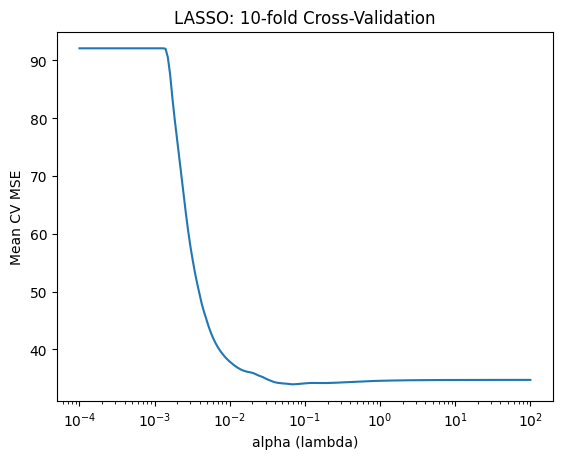

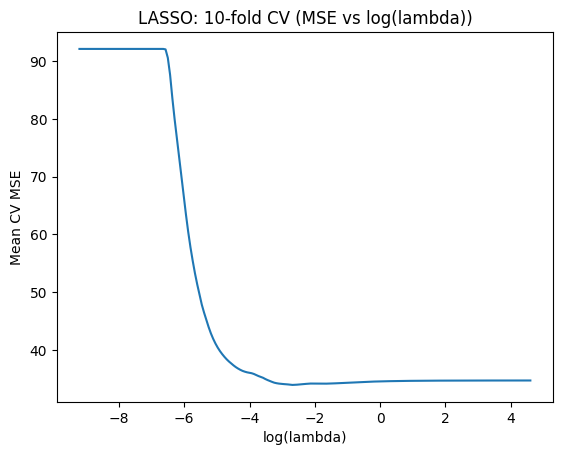

Training MSE at optimal alpha: 22.85952


In [ ]:
# ------------------------------------------------------------
# 1.1.4 Cross Validation to Search Optimal Tuning Parameter in LASSO
# R reference:
# lasso_fit  <- glmnet(x=..., y=..., alpha=1)
# cv_lasso_fit <- cv.glmnet(x=..., y=..., alpha=1, nfolds=10)
# plot(cv_lasso_fit)
#
# Python analogue: sklearn LassoCV (10-fold CV) to select alpha (lambda)
# Note: In glmnet, lambda is the penalty parameter. In sklearn, alpha plays
# the same role (alpha ≈ lambda, up to scaling conventions).
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# 1) Define X and y (from your existing df)
X = df.drop(columns=["medv"]).values
y = df["medv"].values

# 2) Fit a LASSO model over a path of alphas (like glmnet)
#    (optional, mainly for completeness)
lasso_fit = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=100000))
])
lasso_fit.fit(X, y)

# 3) 10-fold CV to choose the optimal alpha (lambda)
#    Use a log-spaced grid for alphas (you can widen/narrow as needed)
alphas = np.logspace(-4, 2, 200)

lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_cv", LassoCV(alphas=alphas, cv=10, max_iter=100000, random_state=123))
])

lasso_cv.fit(X, y)

best_alpha = lasso_cv.named_steps["lasso_cv"].alpha_
print("Optimal alpha (lambda) from 10-fold CV:", best_alpha)

# 4) Plot CV curve (similar to plot(cv.glmnet))
# sklearn stores mean MSE across folds for each alpha in mse_path_
mse_path = lasso_cv.named_steps["lasso_cv"].mse_path_  # shape: (n_alphas, n_folds)
mean_mse = mse_path.mean(axis=1)
std_mse = mse_path.std(axis=1)

plt.figure()
plt.semilogx(alphas, mean_mse)
plt.xlabel("alpha (lambda)")
plt.ylabel("Mean CV MSE")
plt.title("LASSO: 10-fold Cross-Validation")
plt.show()

# ------------------------------------------------------------
# Plot: Mean Squared Error vs log(lambda)   (lambda == alpha grid)
# ------------------------------------------------------------

# mean_mse already computed above; if not, uncomment the next 2 lines:
# mse_path = lasso_cv.named_steps["lasso_cv"].mse_path_
# mean_mse = mse_path.mean(axis=1)

log_lambda = np.log(alphas)

plt.figure()
plt.plot(log_lambda, mean_mse)
plt.xlabel("log(lambda)")
plt.ylabel("Mean CV MSE")
plt.title("LASSO: 10-fold CV (MSE vs log(lambda))")
plt.show()


# (Optional) Fit final LASSO using the selected alpha and report training MSE
final_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=best_alpha, max_iter=100000))
])
final_lasso.fit(X, y)
y_hat = final_lasso.predict(X)
print("Training MSE at optimal alpha:", round(mean_squared_error(y, y_hat), 5))


In [ ]:
# ------------------------------------------------------------
# R -> Python: Best penalty, coefficients, predictions, and MAE
#
# Note:
# R uses glmnet/cv.glmnet to pick lambda.min.
# In Python, the closest equivalent is LassoCV, which performs cross-validation
# and selects the optimal penalty parameter alpha_ (the Python counterpart to lambda).
# ------------------------------------------------------------

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_absolute_error

# Assumes df already exists from your Boston data-loading cell
X = df.drop(columns=["medv"]).values
y = df["medv"].values

# If lasso_cv was not created earlier, create it here (10-fold CV)
alphas = np.logspace(-4, 2, 200)

lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso_cv", LassoCV(alphas=alphas, cv=10, max_iter=100000, random_state=123))
])
lasso_cv.fit(X, y)

# 1) Best penalty: Python alpha_ (counterpart to R's lambda.min)
alpha = lasso_cv.named_steps["lasso_cv"].alpha_
print("Best alpha (counterpart to lambda.min):", alpha)

# 2) Fit LASSO at best alpha
lasso_at_alpha = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=alpha, max_iter=100000))
])
lasso_at_alpha.fit(X, y)

# 3) Coefficients (including intercept) in a tidy table
feature_names = df.drop(columns=["medv"]).columns.to_list()
coef = lasso_at_alpha.named_steps["lasso"].coef_
intercept = lasso_at_alpha.named_steps["lasso"].intercept_

coef_table = pd.DataFrame({
    "feature": ["(Intercept)"] + feature_names,
    "coef": [intercept] + coef.tolist()
})

# Match glmnet-style display: show "." for exact zeros
coef_table["coef_glmnet_style"] = coef_table["coef"].apply(
    lambda v: "." if np.isclose(v, 0.0) else v
)

display(coef_table[["feature", "coef_glmnet_style"]])

# 4) Predictions at best alpha
y_pred = lasso_at_alpha.predict(X)

# 5) MAE
mae = mean_absolute_error(y, y_pred)
print("MAE at best alpha:", round(mae, 6))


Best alpha (counterpart to lambda.min): 0.14649713983072848


,feature,coef_glmnet_style
0,(Intercept),22.532806
1,CRIM,-0.495028
2,ZN,0.535823
3,INDUS,-0.060441
4,CHAS,0.645896
5,NOX,-1.355587
6,RM,2.896056
7,AGE,.
8,DIS,-2.101031
9,RAD,0.518394


MAE at best alpha: 3.267309


### 1.1.5 (Optional) Supplementary: DAAG `cv.lm` Analogue in Python

In R, the **DAAG** package provides `cv.lm()` to run cross-validation for a linear model and prints the error in each fold, followed by a plot.

In Python, we can replicate this workflow using **`KFold`** from scikit-learn:

- Set `n_splits = 3` to match `m = 3` in `cv.lm(..., m = 3)`.
- Fit the linear regression model on each training fold and evaluate on the test fold.
- Print the **test MSE** for each fold.
- Store fold errors in a list (so CV errors are available programmatically).
- Plot fold-wise MSE at the end.


3-Fold CV results (MSE by fold):
  Fold 1: MSE = 50.12444  (n_test = 169)
  Fold 2: MSE = 38.76998  (n_test = 169)
  Fold 3: MSE = 30.73746  (n_test = 168)

Summary:
  Mean CV MSE: 39.87729
  Std  CV MSE: 7.95334


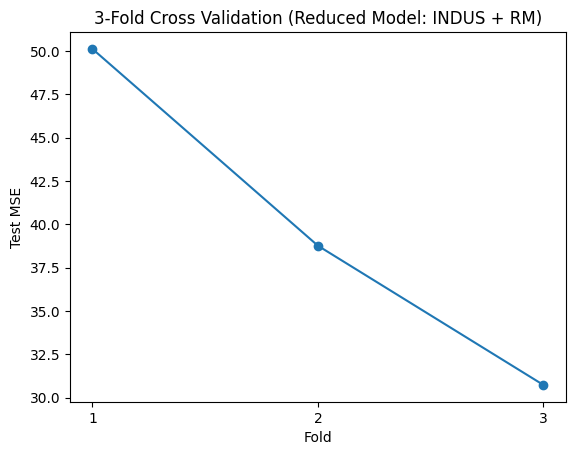

In [ ]:
# ------------------------------------------------------------
# (Optional) Supplementary: DAAG::cv.lm analogue in Python
# R reference:
# library(DAAG)
# model_2 <- lm(medv~indus + rm, data = Boston)
# cv3 <- cv.lm(data = Boston, form.lm = model_2, m=3)
#
# In Python, we can replicate this behavior using KFold:
# - prints fold performance
# - can also produce a simple plot at the end
# - and (unlike DAAG in your note) we CAN collect errors programmatically
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Reduced model: medv ~ INDUS + RM
X = df[["INDUS", "RM"]].values
y = df["medv"].values

# m = 3 folds (like cv.lm(..., m=3))
kf3 = KFold(n_splits=3, shuffle=True, random_state=123)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

fold_mse = []
fold_sizes = []

print("3-Fold CV results (MSE by fold):")
for fold, (train_idx, test_idx) in enumerate(kf3.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    fold_mse.append(mse)
    fold_sizes.append(len(test_idx))

    print(f"  Fold {fold}: MSE = {mse:.5f}  (n_test = {len(test_idx)})")

fold_mse = np.array(fold_mse)

print("\nSummary:")
print("  Mean CV MSE:", round(fold_mse.mean(), 5))
print("  Std  CV MSE:", round(fold_mse.std(), 5))

# Plot fold-wise performance (similar spirit to DAAG's end plot)
plt.figure()
plt.plot(np.arange(1, len(fold_mse) + 1), fold_mse, marker="o")
plt.xlabel("Fold")
plt.ylabel("Test MSE")
plt.title("3-Fold Cross Validation (Reduced Model: INDUS + RM)")
plt.xticks([1, 2, 3])
plt.show()


In [ ]:
%%shell
jupyter nbconvert --to html ///content/5_A_Cross_Validation.ipynb

[NbConvertApp] Converting notebook ///content/5_A_Cross_Validation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 450969 bytes to /content/5_A_Cross_Validation.html
